<a href="https://colab.research.google.com/github/rufusabu/Crypto/blob/master/FastAI_Lesson_1_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Classifier

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
!nvidia-smi

Fri Nov 29 04:11:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

In [5]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## FastAI Setup

Make necessary FastAI imports.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64

Downloading and extracting the CIFAR-10 dataset.

In [0]:
path = untar_data(URLs.CIFAR)

In [16]:
path

PosixPath('/root/.fastai/data/cifar10')

In [17]:
path.ls()

[PosixPath('/root/.fastai/data/cifar10/labels.txt'),
 PosixPath('/root/.fastai/data/cifar10/train'),
 PosixPath('/root/.fastai/data/cifar10/test')]

In [19]:
!cat data/cifar10/labels.txt

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


In [0]:
train_path = path/'train'
test_path = path/'test'
base_path = path/''

In [51]:
print(train_path,
      test_path,
      base_path)

/root/.fastai/data/cifar10/train /root/.fastai/data/cifar10/test /root/.fastai/data/cifar10


In [23]:
doc(get_image_files)

In [24]:
imgList = ImageList.from_folder(train_path); imgList

ImageList (50000 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /root/.fastai/data/cifar10/train

In [37]:
imgList.items[:10]

array([PosixPath('/root/.fastai/data/cifar10/train/ship/28918_ship.png'),
       PosixPath('/root/.fastai/data/cifar10/train/ship/15607_ship.png'),
       PosixPath('/root/.fastai/data/cifar10/train/ship/2599_ship.png'),
       PosixPath('/root/.fastai/data/cifar10/train/ship/32691_ship.png'),
       PosixPath('/root/.fastai/data/cifar10/train/ship/20455_ship.png'),
       PosixPath('/root/.fastai/data/cifar10/train/ship/9692_ship.png'),
       PosixPath('/root/.fastai/data/cifar10/train/ship/18395_ship.png'),
       PosixPath('/root/.fastai/data/cifar10/train/ship/38969_ship.png'),
       PosixPath('/root/.fastai/data/cifar10/train/ship/37335_ship.png'),
       PosixPath('/root/.fastai/data/cifar10/train/ship/2798_ship.png')], dtype=object)

## Preprocessing

Create an image data bunch.

In [38]:
doc(ImageDataBunch.from_folder)

Our data is organized into two folders - `train` and `test`. In each folder, the data is arranged into subfolders for each class. This type of arrangement is called the `Imagenet` style arrangement. We will use the `ImageDataBunch.from_folder` method to create an image data bunch from the train and test folders. First we provide the base path and then specify what the train and validation folders are called. Then we specify the batch size and the size of each image array. Next, we normalize it by `imagenet_stats`.

In [0]:
data = ImageDataBunch.from_folder(path = str(base_path), train = "train", valid = "test", bs = bs, size = 224).normalize(imagenet_stats)

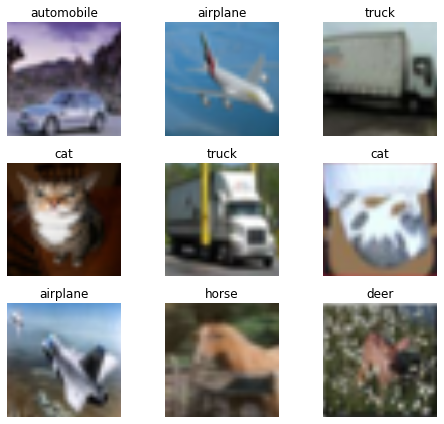

In [69]:
data.show_batch(rows = 3, figsize = (7, 6))

In [70]:
print(data.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Training ResNet34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics = error_rate)

In [72]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [73]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.490501,0.351873,0.112900,03:10
1,0.288225,0.216776,0.075600,03:10
2,0.192856,0.182077,0.063400,03:08
3,0.181204,0.175937,0.061100,03:05


In [0]:
learn.save('cifar10-Resnet34-stage1')

## Result

In [76]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [77]:
losses

tensor([9.4085, 8.4786, 7.8399,  ..., -0.0000, -0.0000, -0.0000])

In [78]:
idxs

tensor([4948, 4200, 6610,  ...,  317, 3119, 3778])

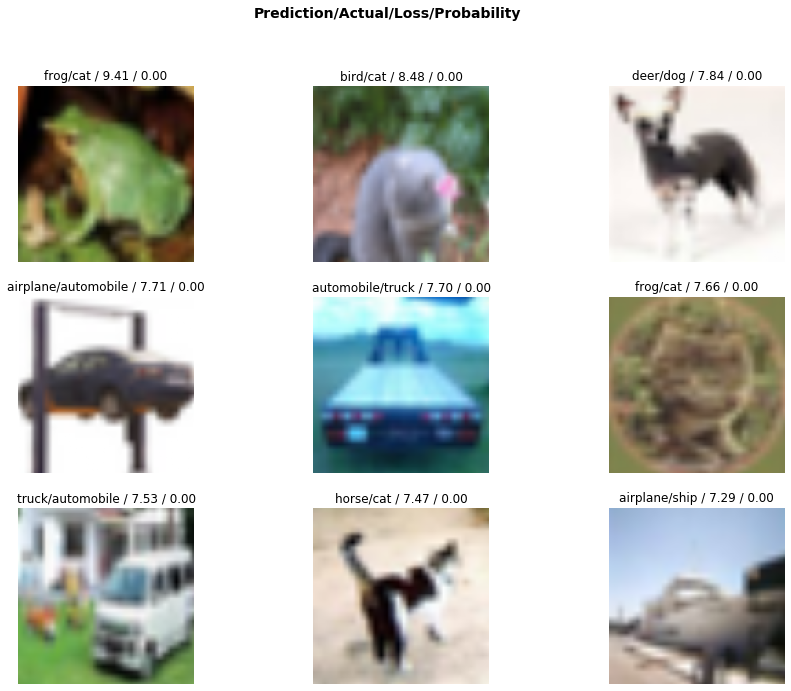

In [81]:
interp.plot_top_losses(9, figsize = (15, 11))

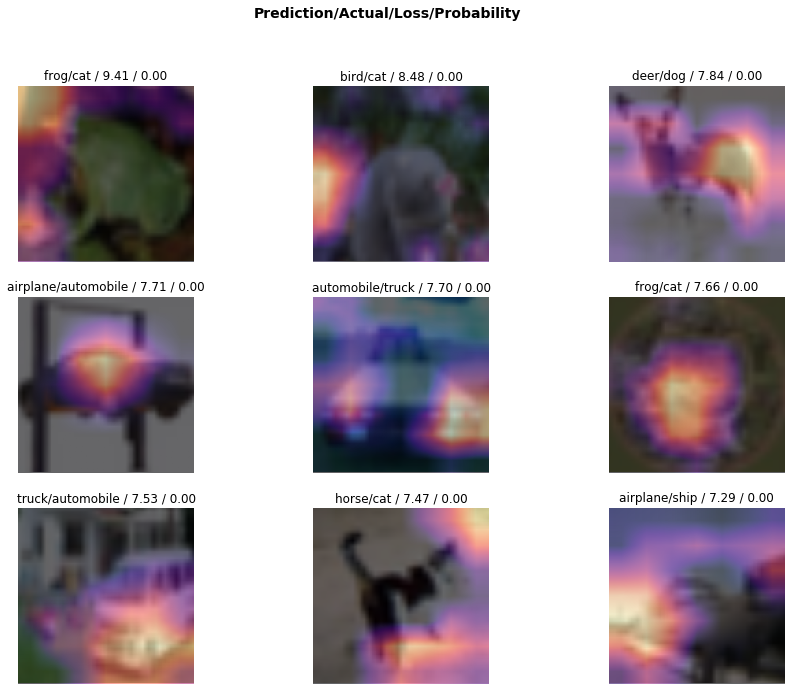

In [82]:
interp.plot_top_losses(9, figsize = (15, 11), heatmap = True)

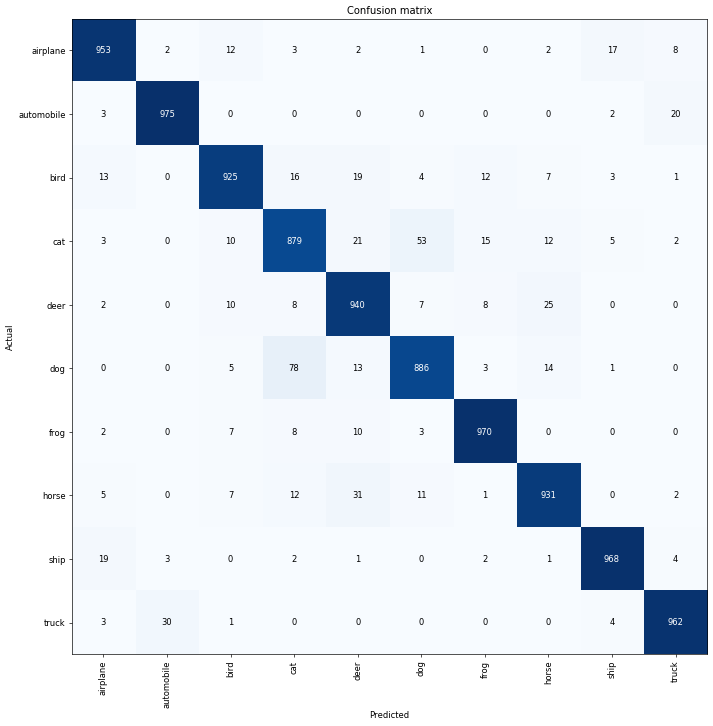

In [83]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [84]:
print("Actual vs Prediction")
interp.most_confused(min_val=2)

Actual vs Prediction


[('dog', 'cat', 78),
 ('cat', 'dog', 53),
 ('horse', 'deer', 31),
 ('truck', 'automobile', 30),
 ('deer', 'horse', 25),
 ('cat', 'deer', 21),
 ('automobile', 'truck', 20),
 ('bird', 'deer', 19),
 ('ship', 'airplane', 19),
 ('airplane', 'ship', 17),
 ('bird', 'cat', 16),
 ('cat', 'frog', 15),
 ('dog', 'horse', 14),
 ('bird', 'airplane', 13),
 ('dog', 'deer', 13),
 ('airplane', 'bird', 12),
 ('bird', 'frog', 12),
 ('cat', 'horse', 12),
 ('horse', 'cat', 12),
 ('horse', 'dog', 11),
 ('cat', 'bird', 10),
 ('deer', 'bird', 10),
 ('frog', 'deer', 10),
 ('airplane', 'truck', 8),
 ('deer', 'cat', 8),
 ('deer', 'frog', 8),
 ('frog', 'cat', 8),
 ('bird', 'horse', 7),
 ('deer', 'dog', 7),
 ('frog', 'bird', 7),
 ('horse', 'bird', 7),
 ('cat', 'ship', 5),
 ('dog', 'bird', 5),
 ('horse', 'airplane', 5),
 ('bird', 'dog', 4),
 ('ship', 'truck', 4),
 ('truck', 'ship', 4),
 ('airplane', 'cat', 3),
 ('automobile', 'airplane', 3),
 ('bird', 'ship', 3),
 ('cat', 'airplane', 3),
 ('dog', 'frog', 3),
 ('frog

## Unfreezing, Relearning and Improving

Finding optimum Learning Rate

In [85]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


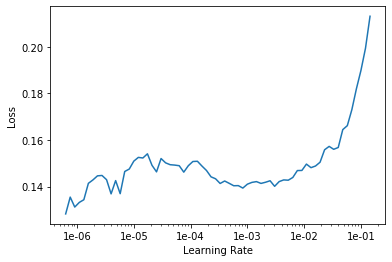

In [86]:
learn.recorder.plot()

Refitting with new LR limit

In [90]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.449669,0.431881,0.144500,03:20
1,0.158926,0.162023,0.053300,03:18


We've reduced the error rate from 6% to 5% by unfreezing and limiting the learning rate range.